In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

input_path = '/Users/danasour/PycharmProjects/GLUSAP/notebooks/results'

adults = ['adult#001', 'adult#002', 'adult#004', 'adult#005', 'adult#008', 'adult#009', 'adult#010']

adult_info = {
    'adult#001': {'CR': 10, 'CF': 8.77, 'Age': 61, 'TDI': 50.42},
    'adult#002': {'CR': 8, 'CF': 9.21, 'Age': 65, 'TDI': 57.87},
    'adult#004': {'CR': 16, 'CF': 42.65, 'Age': 66, 'TDI': 33.81},
    'adult#005': {'CR': 5, 'CF': 8.23, 'Age': 52, 'TDI': 68.32},
    'adult#008': {'CR': 13, 'CF': 12.25, 'Age': 48, 'TDI': 42.78},
    'adult#009': {'CR': 5, 'CF': 7.64, 'Age': 68, 'TDI': 67.21},
    'adult#010': {'CR': 5, 'CF': 10.69, 'Age': 68, 'TDI': 64.45}
}

def get_data(adult, input_path, days=0):
    data = []
    for i in range(1, 14):
        path = os.path.join(input_path, f'simulation_{i}', adult)
        df = pd.read_csv(path)
        df['Time'] = pd.to_datetime(df['Time'])
        # sum 1 day to the date
        df['Time'] = df['Time'] + pd.DateOffset(days=days)
        days = days + 1
        data.append(df)
    return pd.concat(data)

adult = 'adult#001.csv'
input_path = '/Users/danasour/PycharmProjects/GLUSAP/notebooks/results'
data = get_data(adult, input_path)


In [3]:
adult_static_info = adult_info['adult#001']
data['CR'] = adult_static_info['CR']
data['CF'] = adult_static_info['CF']
data['Age'] = adult_static_info['Age']
data['TDI'] = adult_static_info['TDI']

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-32520.286, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6584.265, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-242.754, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-31768.309, Time=0.89 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-32428.035, Time=0.89 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-32637.405, Time=0.34 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-32457.389, Time=0.75 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-32411.640, Time=3.41 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-32673.054, Time=1.70 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-32575.165, Time=0.75 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-32658.100, Time=0.99 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-32675.829, Time=0.97 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-32604.032, Time=1.02 sec
 ARIMA(4,0,4)(0,

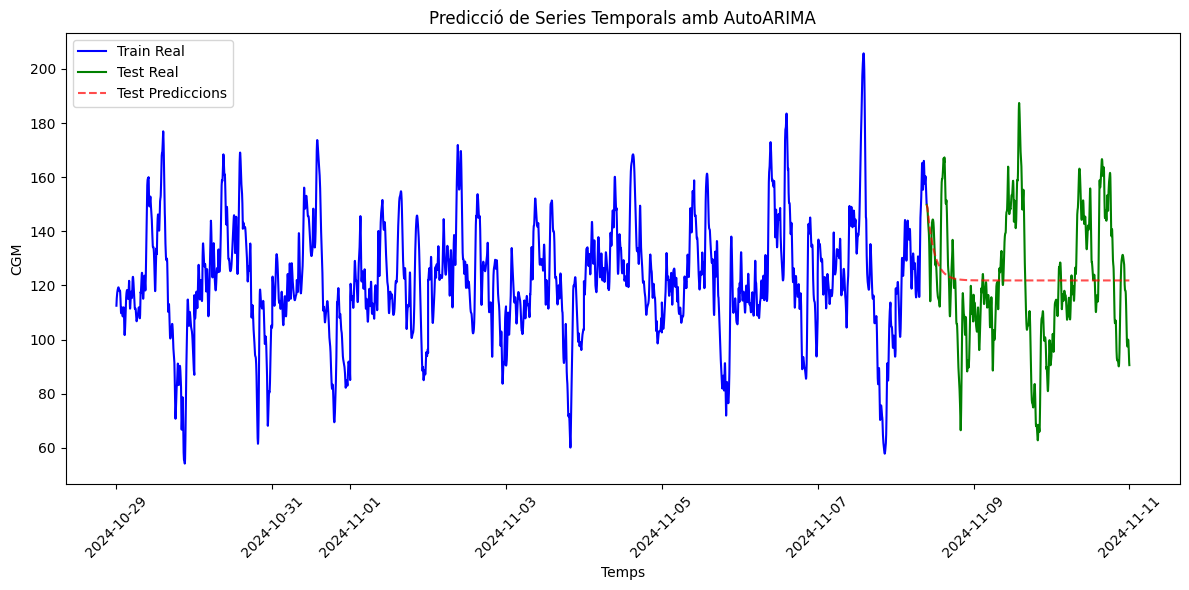

In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima

from scipy import stats

data = pd.read_csv('/Users/danasour/PycharmProjects/GLUSAP/notebooks/results/adult#001.csv')
data['Time'] = pd.to_datetime(data['Time'])

data['CGM_boxcox'], _ = stats.boxcox(data['CGM'] + 1)  # Asegura't que no hi ha valors negatius

scaler = MinMaxScaler(feature_range=(0, 1))
targets = data['CGM_boxcox'].values  # Obtener la serie temporal per a la predicció
targets_normalized = scaler.fit_transform(targets.reshape(-1, 1)).flatten()  # Normalitza i aplana

split_ratio = 0.8
train_size = int(len(targets_normalized) * split_ratio)
train_data, test_data = targets_normalized[:train_size], targets_normalized[train_size:]

model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)
print(model.summary())

train_predictions = model.predict(n_periods=len(train_data))
test_predictions = model.predict(n_periods=len(test_data))

train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train_true = scaler.inverse_transform(train_data.reshape(-1, 1))
y_test_true = scaler.inverse_transform(test_data.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(data['Time'][:train_size], y_train_true, label='Train Real', color='blue')
plt.plot(data['Time'][train_size:], y_test_true, label='Test Real', color='green')
plt.plot(data['Time'][train_size:], test_predictions, label='Test Prediccions', linestyle='--', color='red', alpha=0.7)
plt.legend()
plt.title('Predicció de Series Temporals amb AutoARIMA')
plt.xlabel('Temps')
plt.ylabel('CGM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()